In [1]:
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats


In [2]:
# File paths
base_folder = r'F:\AlterG\Control\Data'  # Adjust this path as needed


In [3]:
def load_participant_data(participant_number):
    participant_folder = os.path.join(base_folder, f"{participant_number:02d}")
    kinematics_path = os.path.join(participant_folder, 'Kinematics', 'concatenated_strides.pkl')
    
    if os.path.exists(kinematics_path):
        with open(kinematics_path, 'rb') as f:
            participant_data = pickle.load(f)
            return participant_data
    else:
        print(f"No data found for Participant {participant_number}")
        return None


In [4]:
def compute_mean_and_variability(strides_list, variability='CI'):
    """
    Computes the mean stride and variability (SD, SE, or 95% CI) across a list of strides.

    Parameters:
    - strides_list: List of stride_info dictionaries containing 'processed_stride_data'.
    - variability: Type of variability to compute ('SD', 'SE', or 'CI').

    Returns:
    - mean_stride: Numpy array of the mean stride.
    - lower_bound: Numpy array of the lower bound of the variability area.
    - upper_bound: Numpy array of the upper bound of the variability area.
    """
    if not strides_list:
        return None, None, None

    # Collect all processed stride data
    stride_data_list = [stride_info['processed_stride_data'] for stride_info in strides_list]
    # Stack stride data into a 2D array (strides x data points)
    stride_data_array = np.stack(stride_data_list, axis=0)
    # Compute the mean across strides
    mean_stride = np.mean(stride_data_array, axis=0)

    # Compute variability
    if variability == 'SD':
        var_stride = np.std(stride_data_array, axis=0)
        lower_bound = mean_stride - var_stride
        upper_bound = mean_stride + var_stride
    elif variability == 'SE':
        var_stride = np.std(stride_data_array, axis=0) / np.sqrt(stride_data_array.shape[0])
        lower_bound = mean_stride - var_stride
        upper_bound = mean_stride + var_stride
    elif variability == 'CI':
        confidence = 0.95
        n = stride_data_array.shape[0]
        stderr = stats.sem(stride_data_array, axis=0)
        t_value = stats.t.ppf((1 + confidence) / 2., n - 1)
        margin_of_error = t_value * stderr
        lower_bound = mean_stride - margin_of_error
        upper_bound = mean_stride + margin_of_error
    else:
        raise ValueError("Invalid variability type. Choose 'SD', 'SE', or 'CI'.")

    return mean_stride, lower_bound, upper_bound


In [5]:
def display_participant_summary(participant_data):
    if participant_data is not None:
        print("Participant Summary:")
        for header in participant_data:
            header_type = participant_data[header].get('header_type', 'unknown')
            if header_type == 'bilateral':
                right_count = len(participant_data[header].get('strides_r', []))
                left_count = len(participant_data[header].get('strides_l', []))
                print(f"- {header}: Right Strides: {right_count}, Left Strides: {left_count}")
            elif header_type == 'right_only':
                right_count = len(participant_data[header].get('strides_r', []))
                print(f"- {header}: Right Strides: {right_count}")
            elif header_type == 'left_only':
                left_count = len(participant_data[header].get('strides_l', []))
                print(f"- {header}: Left Strides: {left_count}")
            else:
                print(f"- {header}: Unknown header type")
    else:
        print("No data available to display participant summary.")


In [10]:
def plot_stride_data(participant_data, header, side=None, variability_type='CI'):
    if participant_data is not None and header in participant_data:
        stride_data = participant_data[header]
        header_type = stride_data.get('header_type', 'unknown')

        # Determine the side key based on 'r' or 'l'
        if side is None:
            if header_type == 'right_only':
                side = 'Right'
            elif header_type == 'left_only':
                side = 'Left'
            elif header_type == 'bilateral':
                side = input("Enter side ('Right' or 'Left'): ")
                if side not in ['Right', 'Left']:
                    print("Invalid side. Please enter 'Right' or 'Left'.")
                    return
            else:
                print(f"Unknown header type for '{header}'.")
                return

        # Map 'Right'/'Left' to 'r'/'l' to match your data keys
        side_key = 'r' if side.lower() == 'right' else 'l'

        # Access the correct strides list
        strides = stride_data.get(f'strides_{side_key}', [])

        if strides:
            # Check if strides are dictionaries
            if isinstance(strides[0], dict):
                stride_arrays = [s['processed_stride_data'] for s in strides]
                event_lists = [s.get('normalized_events', []) for s in strides]
            else:
                stride_arrays = strides
                event_lists = [[] for _ in strides]  # Empty events if not available

            # Create two subplots side by side
            fig, axs = plt.subplots(1, 2, figsize=(14, 6))

            # Left Plot: All individual strides with events
            axs[0].set_title(f'{header} - {side} Side - All Strides')
            axs[0].set_xlabel('% Gait Cycle')
            axs[0].set_ylabel(header)
            x_values = np.linspace(0, 100, len(stride_arrays[0]))

            # Define event styles
            event_styles = {
                'ipsi_toe_off': {'color': 'green', 'linestyle': '--', 'label': 'Ipsi Toe Off'},
                'contra_heel_strike': {'color': 'blue', 'linestyle': '-.', 'label': 'Contra Heel Strike'},
                'contra_toe_off': {'color': 'purple', 'linestyle': ':', 'label': 'Contra Toe Off'},
                # Add more event types as needed
            }
            # Keep track of plotted event types for legend
            plotted_event_types = {}

            for stride, events in zip(stride_arrays, event_lists):
                axs[0].plot(x_values, stride, alpha=0.3)

                # Plot normalized events as vertical lines
                for event in events:
                    event_idx = event.get('normalized_index')
                    event_type = event.get('type', 'Event')
                    if event_idx is not None and 0 <= event_idx < len(x_values):
                        event_position = x_values[event_idx]
                        style = event_styles.get(event_type, {'color': 'gray', 'linestyle': '--', 'label': event_type})
                        axs[0].axvline(x=event_position, color=style['color'], linestyle=style['linestyle'], alpha=0.5)
                        # Add to legend only once
                        if event_type not in plotted_event_types:
                            plotted_event_types[event_type] = style['label']

            # Add legend for events
            if plotted_event_types:
                handles = [plt.Line2D([0], [0], color=event_styles[etype]['color'],
                                      linestyle=event_styles[etype]['linestyle'],
                                      label=label)
                           for etype, label in plotted_event_types.items()]
                axs[0].legend(handles=handles, loc='upper right')

            axs[0].grid(True)

            # Right Plot: Mean stride with variability
            mean_stride, lower, upper = compute_mean_and_variability(
                [{'processed_stride_data': s} for s in stride_arrays], variability=variability_type
            )
            if mean_stride is not None:
                axs[1].set_title(f'{header} - {side} Side - Mean ± {variability_type}')
                axs[1].set_xlabel('% Gait Cycle')
                axs[1].set_ylabel(header)
                x_values_mean = np.linspace(0, 100, len(mean_stride))
                axs[1].plot(x_values_mean, mean_stride, color='red', label='Mean')
                axs[1].fill_between(x_values_mean, lower, upper, color='red', alpha=0.2, label=f'{variability_type}')
                axs[1].legend()
                axs[1].grid(True)

                # Optionally, plot mean event positions
                # Collect all normalized event indices by event type
                event_indices_by_type = {}
                for events in event_lists:
                    for event in events:
                        event_idx = event.get('normalized_index')
                        event_type = event.get('type', 'Event')
                        if event_idx is not None:
                            event_indices_by_type.setdefault(event_type, []).append(event_idx)

                # Plot mean event positions
                for event_type, indices in event_indices_by_type.items():
                    mean_event_idx = int(np.mean(indices))
                    event_position = x_values_mean[mean_event_idx]
                    style = event_styles.get(event_type, {'color': 'gray', 'linestyle': '--', 'label': event_type})
                    axs[1].axvline(x=event_position, color=style['color'], linestyle=style['linestyle'],
                                   alpha=0.8, label=style['label'])

                # Add legend for mean events
                if event_indices_by_type:
                    handles = [plt.Line2D([0], [0], color=event_styles[etype]['color'],
                                          linestyle=event_styles[etype]['linestyle'],
                                          label=event_styles[etype]['label'])
                               for etype in event_indices_by_type]
                    axs[1].legend(handles=handles + [plt.Line2D([0], [0], color='red', label='Mean')], loc='upper right')

            else:
                axs[1].text(0.5, 0.5, 'No data available for mean plot.',
                            horizontalalignment='center', verticalalignment='center')
                axs[1].set_title('No Data')
                axs[1].set_xlabel('% Gait Cycle')
                axs[1].set_ylabel(header)
                axs[1].grid(True)

            plt.tight_layout()
            plt.show()
        else:
            print(f"No stride data available for {header} - {side} Side.")
    else:
        print(f"Header '{header}' not found in participant data.")


In [11]:
def visualize_participant(participant_number):
    # Load the participant data
    participant_data = load_participant_data(participant_number)

    if participant_data is None:
        return  # Exit if no data is found

    # Display participant summary
    display_participant_summary(participant_data)

    # Allow user to select a header and side to visualize
    while True:
        header = input("Enter the header you wish to visualize (or 'exit' to quit): ")
        if header.lower() == 'exit':
            break

        # Get header_type
        header_type = participant_data.get(header, {}).get('header_type', 'unknown')

        # Determine side
        if header_type == 'bilateral':
            side = input("Enter side ('Right' or 'Left'): ")
            if side not in ['Right', 'Left']:
                print("Invalid side. Please enter 'Right' or 'Left'.")
                continue
        elif header_type == 'right_only':
            side = 'Right'
            print(f"Header '{header}' is right-only.")
        elif header_type == 'left_only':
            side = 'Left'
            print(f"Header '{header}' is left-only.")
        else:
            print(f"Unknown header type for '{header}'.")
            continue

        # Ask for variability type
        variability_type = input("Enter variability type ('SD', 'SE', 'CI'): ").upper()
        if variability_type not in ['SD', 'SE', 'CI']:
            print("Invalid variability type. Defaulting to 'CI'.")
            variability_type = 'CI'

        # Plot stride data for the chosen header and side
        plot_stride_data(participant_data, header, side, variability_type)


Enter the participant number to visualize:  1


Participant Summary:
- time: Right Strides: 49, Left Strides: 50
- pelvis_tilt: Right Strides: 49, Left Strides: 50
- pelvis_list: Right Strides: 49, Left Strides: 50
- pelvis_rotation: Right Strides: 49, Left Strides: 50
- pelvis_tx: Right Strides: 49, Left Strides: 50
- pelvis_ty: Right Strides: 49, Left Strides: 50
- pelvis_tz: Right Strides: 49, Left Strides: 50
- lumbar_extension: Right Strides: 49, Left Strides: 50
- lumbar_bending: Right Strides: 49, Left Strides: 50
- lumbar_rotation: Right Strides: 49, Left Strides: 50
- hip_flexion_r: Right Strides: 49
- hip_adduction_r: Right Strides: 49
- hip_rotation_r: Right Strides: 49
- knee_angle_r: Right Strides: 49
- ankle_angle_r: Right Strides: 49
- subtalar_angle_r: Right Strides: 49
- mtp_angle_r: Right Strides: 49
- hip_flexion_l: Left Strides: 50
- hip_adduction_l: Left Strides: 50
- hip_rotation_l: Left Strides: 50
- knee_angle_l: Left Strides: 50
- ankle_angle_l: Left Strides: 50
- subtalar_angle_l: Left Strides: 50
- mtp_ang

Enter the header you wish to visualize (or 'exit' to quit):  hip_flexion_r


Header 'hip_flexion_r' is right-only.


Enter variability type ('SD', 'SE', 'CI'):  CI


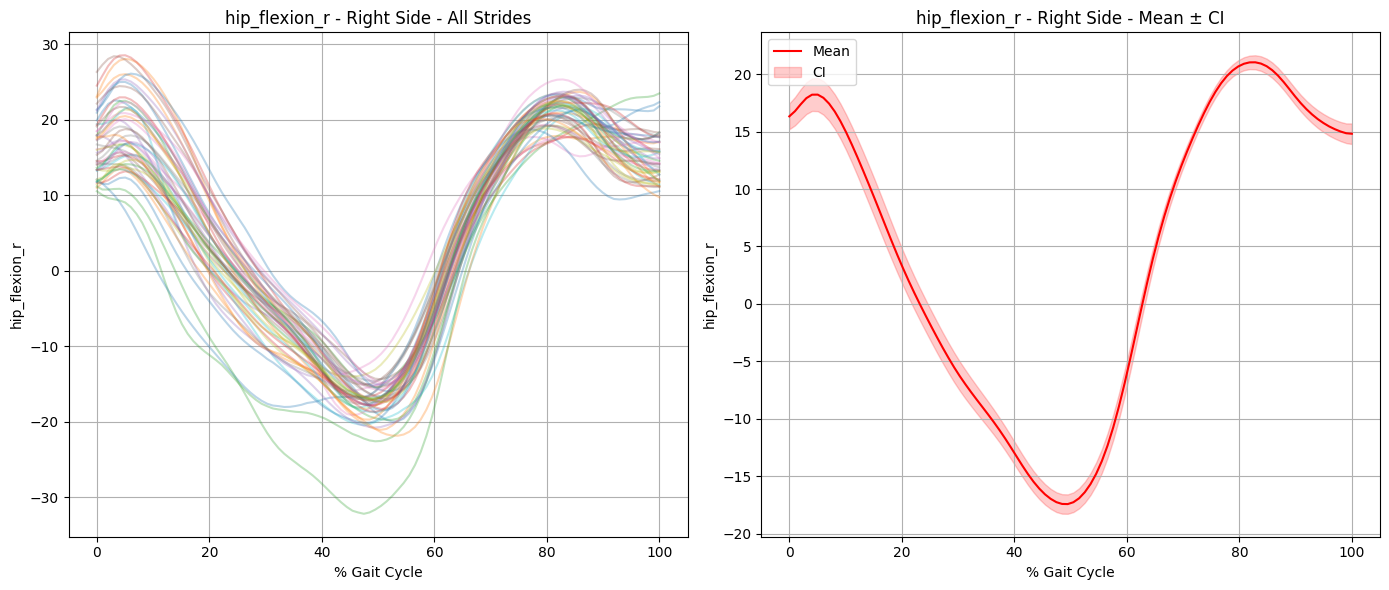

Enter the header you wish to visualize (or 'exit' to quit):  hip_flexion_l


Header 'hip_flexion_l' is left-only.


Enter variability type ('SD', 'SE', 'CI'):  CI


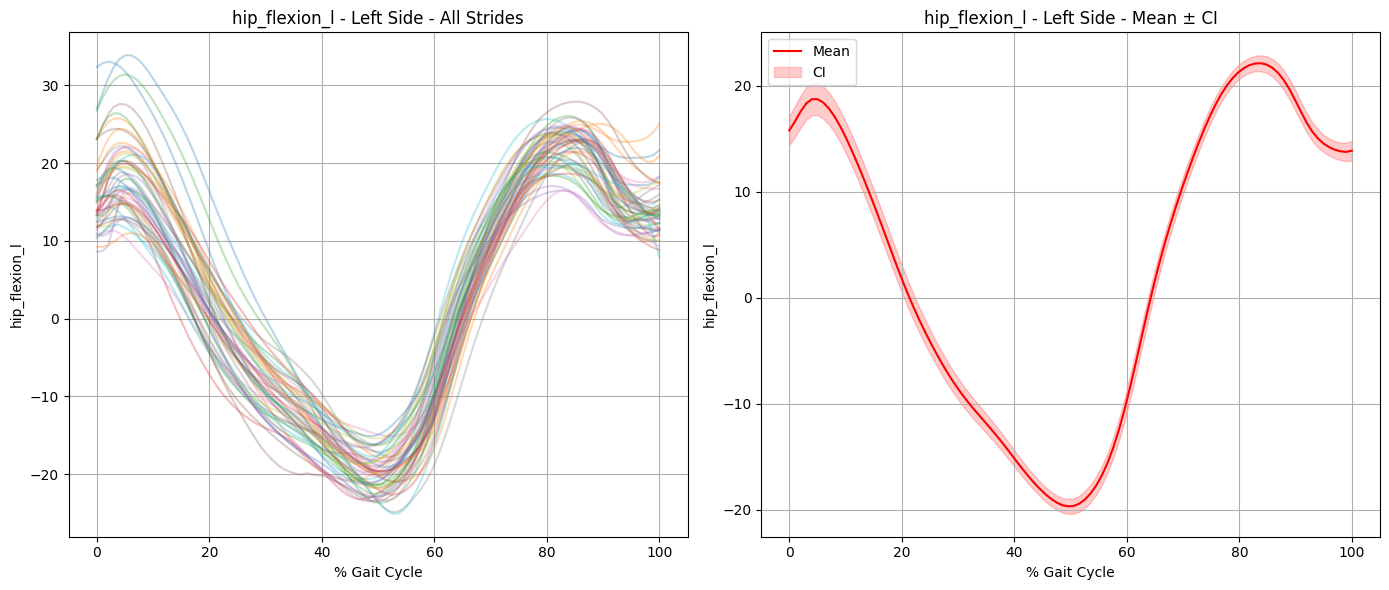

Enter the header you wish to visualize (or 'exit' to quit):  knee_angle_r


Header 'knee_angle_r' is right-only.


Enter variability type ('SD', 'SE', 'CI'):  CI


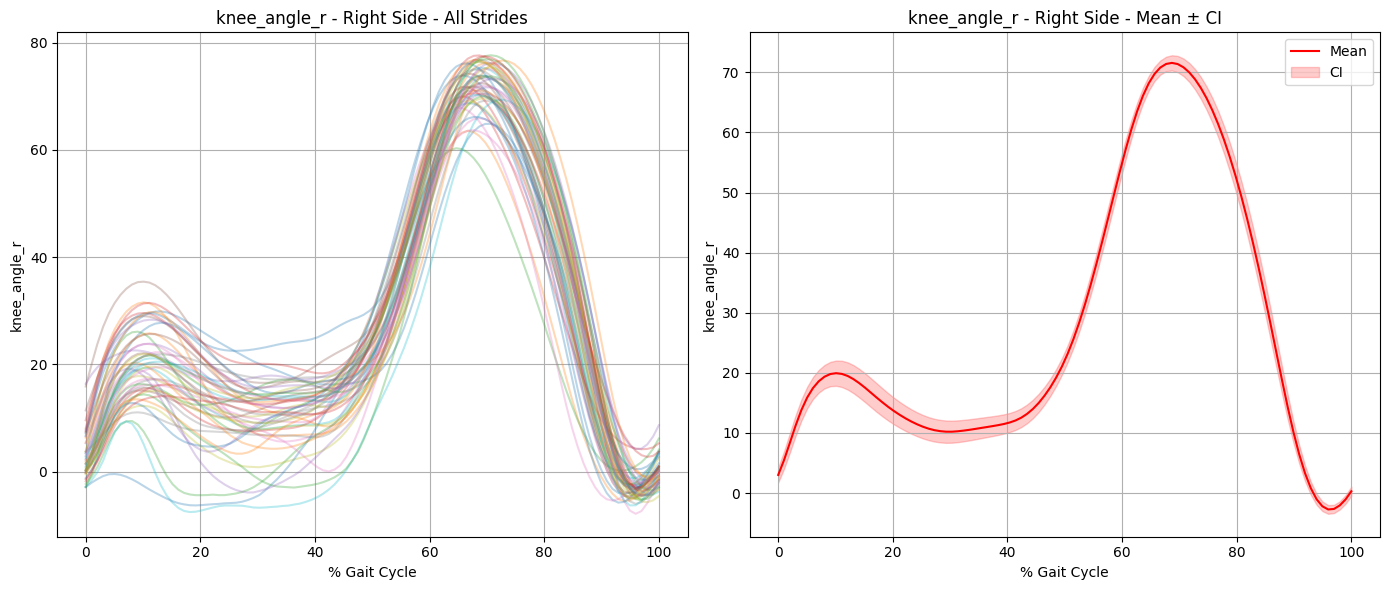

Enter the header you wish to visualize (or 'exit' to quit):  knee_angle_l


Header 'knee_angle_l' is left-only.


Enter variability type ('SD', 'SE', 'CI'):  CI


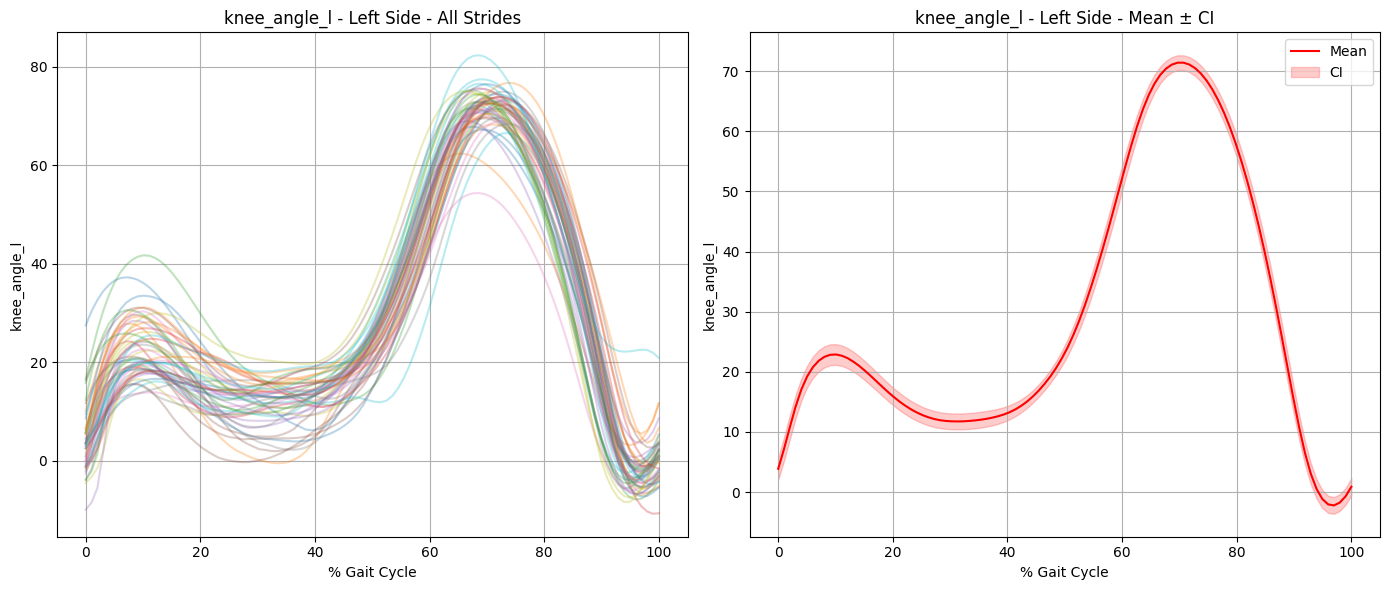

Enter the header you wish to visualize (or 'exit' to quit):  knee_angle_r


Header 'knee_angle_r' is right-only.


Enter variability type ('SD', 'SE', 'CI'):  CI


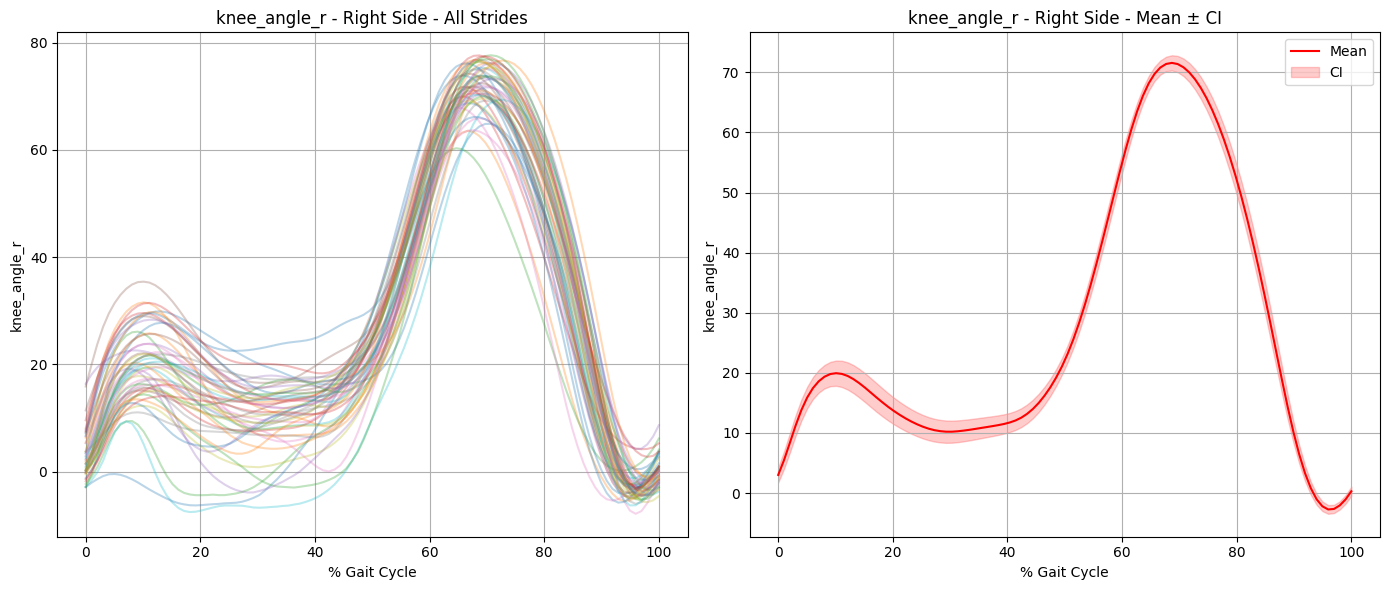

Enter the header you wish to visualize (or 'exit' to quit):  knee_angle_r\


Unknown header type for 'knee_angle_r\'.


Enter the header you wish to visualize (or 'exit' to quit):  knee_angle_r


Header 'knee_angle_r' is right-only.


Enter variability type ('SD', 'SE', 'CI'):  CI


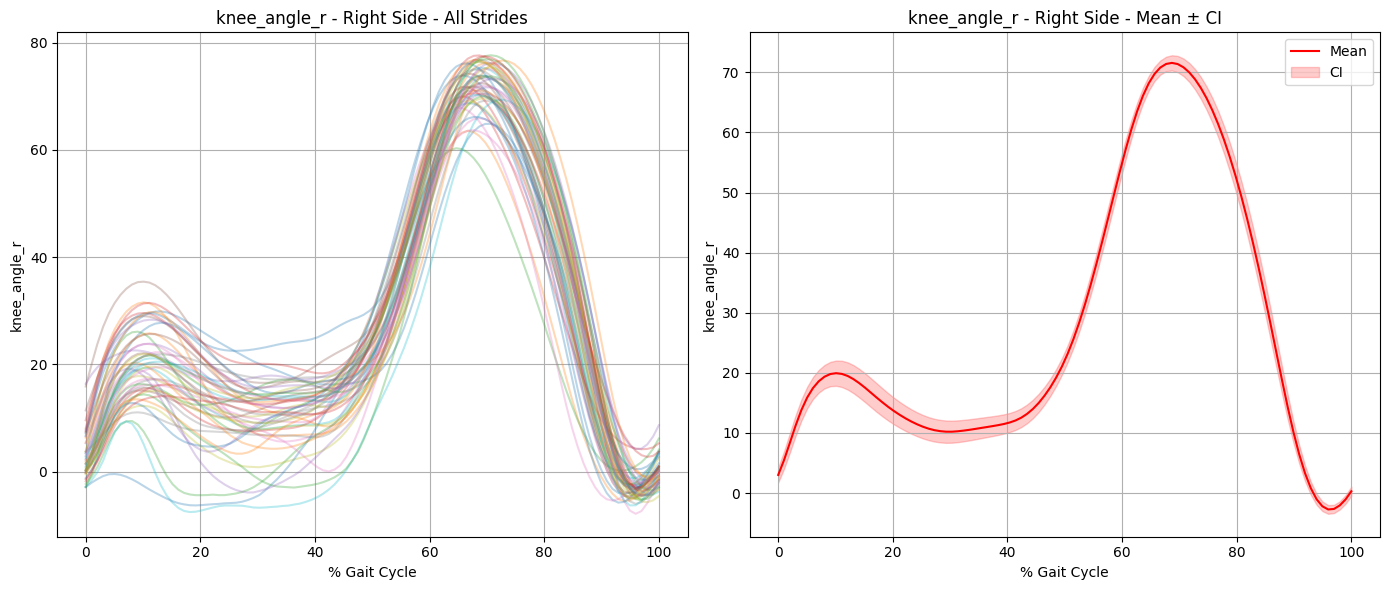

Enter the header you wish to visualize (or 'exit' to quit):  ankle_angle_r


Header 'ankle_angle_r' is right-only.


Enter variability type ('SD', 'SE', 'CI'):  CI


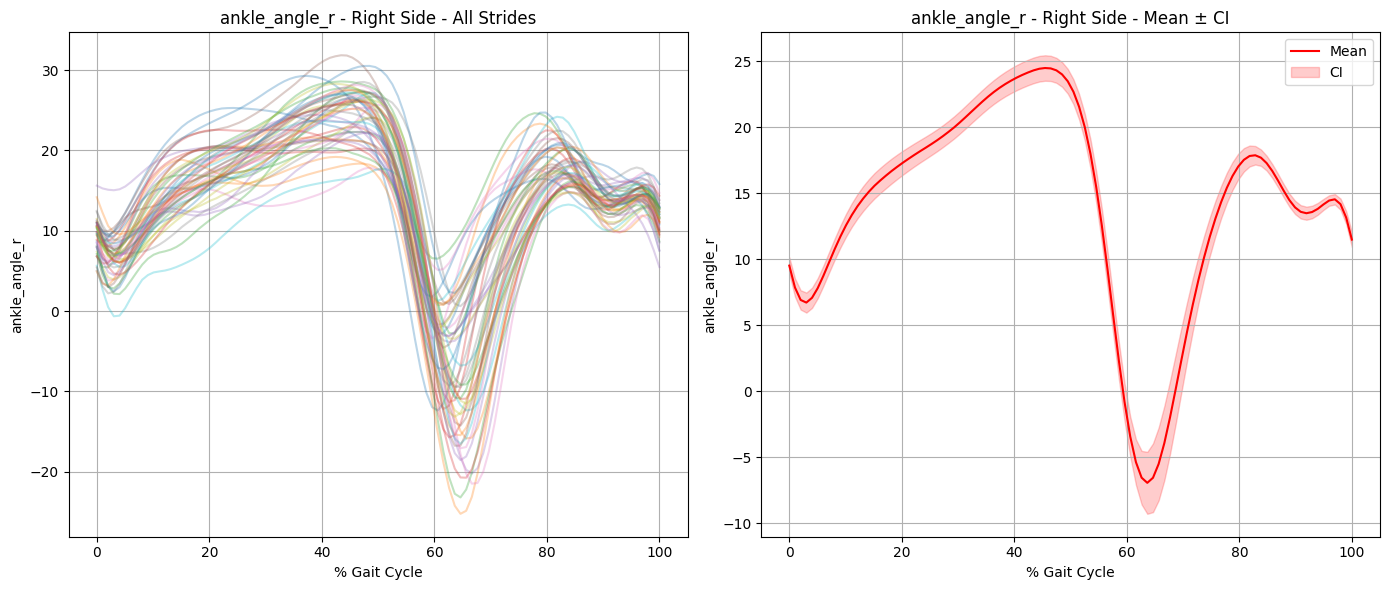

In [ ]:
# Example usage
participant_number = int(input("Enter the participant number to visualize: "))
visualize_participant(participant_number)


In [ ]:
import os
import pickle

# Function to inspect the contents of a pickle file
def inspect_pickle_contents(participant_number):
    participant_folder = os.path.join(base_folder, f"{participant_number:02d}")
    kinematics_path = os.path.join(participant_folder, 'Kinematics', 'concatenated_strides.pkl')

    if os.path.exists(kinematics_path):
        with open(kinematics_path, 'rb') as f:
            participant_data = pickle.load(f)
            print("Inspecting Pickle Contents...\n")
            for header, stride_data in participant_data.items():
                print(f"Header: {header}")
                strides_r = stride_data.get('strides_r', [])
                strides_l = stride_data.get('strides_l', [])
                print(f"  Right Strides Count: {len(strides_r)}")
                print(f"  Left Strides Count: {len(strides_l)}")

                # Print detailed info about the first stride for each side
                if strides_r:
                    print(f"  First Right Stride Keys: {list(strides_r[0].keys())}")
                if strides_l:
                    print(f"  First Left Stride Keys: {list(strides_l[0].keys())}")

                # Optionally, print a sample of the data
                if strides_r:
                    print(f"  Sample Right Stride Data (first 5 points): {strides_r[0]['processed_stride_data'][:5]}")
                if strides_l:
                    print(f"  Sample Left Stride Data (first 5 points): {strides_l[0]['processed_stride_data'][:5]}")

            print("\nEnd of Pickle Inspection\n")
    else:
        print(f"No data found for Participant {participant_number}")


In [9]:
# Load participant data
participant_number = 1
participant_data = load_participant_data(participant_number)

# Access the stride data for 'hip_flexion_r'
header = 'hip_flexion_r'
if header in participant_data:
    stride_data = participant_data[header]
    strides_r = stride_data.get('strides_r', [])
    print(f"Number of right strides: {len(strides_r)}")
    if strides_r:
        print(f"Type of first stride: {type(strides_r[0])}")
        # If it's a dictionary, print its keys
        if isinstance(strides_r[0], dict):
            print("First stride data keys:", strides_r[0].keys())
        else:
            print("First stride is not a dictionary.")
else:
    print(f"Header '{header}' not found in participant data.")


Number of right strides: 49
Type of first stride: <class 'dict'>
First stride data keys: dict_keys(['stride_data', 'start_time', 'end_time', 'events', 'normalized_stride_data', 'normalized_events', 'processed_stride_data'])
